## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.1.0


In [10]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*(np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2)

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*(tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2)

def GP(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = kernel(x,X)
    return 2*(np.squeeze(np.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1

def GPTF(X,A,x,minv = -1.0, maxv = 1.0, l = 0.3):
    k_xX = k_xX = kernelTF(x,X)
    return 2*(tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))-minv)/(maxv-minv)-1


In [11]:
def gen_data(n_train, n_test, n_gp_samples = 8):
    
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))
    X[:,0] = -1.0
    X[:,-1] = 1.0
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))
    l = 0.3

    # Compute and invert the GP Kernel Matrix
    K_XX = kernel(X,X)
    A = np.linalg.inv(K_XX)
    A = np.matmul(A,np.expand_dims(Y,axis=2))
    
    # Compute min and max
    x = np.linspace(-1,1,100).reshape(1,-1)
    y = GP(X, A, x)
    min_val = np.min(y,1).reshape(-1,1)
    max_val = np.max(y,1).reshape(-1,1)
    
    Y = 2*(Y-min_val)/(max_val-min_val)-1
    
    return (X, Y, A, min_val, max_val)

In [12]:
n_train = 16
n_test = 16

X, Y, A, min_val, max_val = gen_data(n_train, n_test, n_gp_samples=8)

X_train = X[:n_train]
Y_train = Y[:n_train]
A_train = A[:n_train]
min_train = min_val[:n_train]
max_train = max_val[:n_train]
X_test = X[-n_test:]
Y_test = Y[-n_test:]
A_test = A[-n_test:]
min_test = min_val[-n_test:]
max_test = max_val[-n_test:]

x = np.linspace(-1,1,100).reshape(1,-1)

print("X:", X.shape)
print("X[0]:", X[0].reshape(1,-1).shape)
print("Y:", Y.shape)

print("A:", A.shape)
print("x:", x.shape)

y = GP(X, A, x, min_val, max_val)

print("y:", y.shape)

X: (32, 8)
X[0]: (1, 8)
Y: (32, 8)
A: (32, 8, 1)
x: (1, 100)
y: (32, 100)


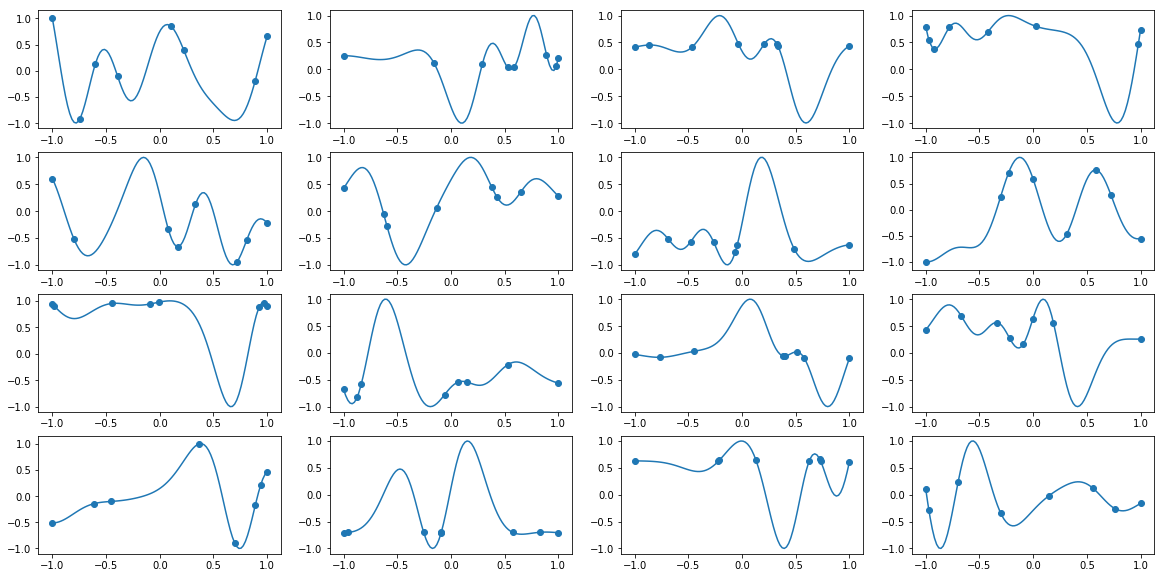

In [13]:
plt.figure(figsize=(20,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.plot(x.flatten(),y[i])
    plt.scatter(X[i],Y[i])
plt.show()

In [14]:
# Number of hidden states in RNN cell
n_hidden = 50

# Sequence length
num_steps = 10

In [15]:
# Create RNN Cell
# x, h = RNN(x, y, h)

variable_dict = {"W1": tf.Variable(tf.truncated_normal([1 + 1 + n_hidden, 100],stddev=0.01), name="W1"),\
                  "b1": tf.Variable(tf.zeros([100]), name="b1"),\
                  "W2": tf.Variable(tf.truncated_normal([100, n_hidden],stddev=0.01), name="W2"),\
                  "b2": tf.Variable(tf.zeros([n_hidden]), name="b2"),\
                  "Wx": tf.Variable(tf.truncated_normal([n_hidden, 1],stddev=0.01), name="Wx"),\
                  "bx": tf.Variable(tf.zeros([1]), name="bx")}

def rnn_cell(x, y, h, v_dict):
    h = tf.tanh(tf.matmul(tf.tanh(tf.matmul(tf.concat([x, y, h], 1),\
                                       v_dict["W1"]) + v_dict["b1"]), v_dict["W2"]) + v_dict["b2"])
    
    #return tf.split(z,[1, n_hidden],axis=1)
    x = tf.matmul(h, v_dict["Wx"]) + v_dict["bx"]
        
    return (x, h) 

In [16]:
# Create Model

size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, 8])
At = tf.placeholder(tf.float32, [None, 8, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, 1])
h_0 = tf.ones([size, n_hidden])#tf.truncated_normal([size, n_hidden],stddev=0.1)

h = h_0
x = x_0
y = GPTF(Xt,At,x, mint, maxt)
sample_points = [x]

f_min = y
f_sum = 0
for i in range(num_steps):
    
    x, h = rnn_cell(x, y, h, variable_dict)
    #x += dx
    sample_points.append(x)
    y = GPTF(Xt,At,x, mint, maxt)
    f_min = tf.minimum(y, f_min)
    
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = (f_sum) / num_steps

In [17]:
#print(sess.run([h], feed_dict={a: a_batch, b: b_batch, c: c_batch, size: batch_size}))

In [18]:
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
#train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1.0).minimize(f_out)

In [19]:
#tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [20]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []

In [22]:
# Train the Network
epochs = 3000
batch_size = 16

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
        A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
        min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
        max_batch = max_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={Xt: X_batch, At: A_batch, size: batch_size, mint: min_batch, maxt: max_batch})
    
    train_loss_list += [sess.run([loss], feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})]
    train_fmin_list += [sess.run([f_min], feed_dict={Xt: X_train, At: A_train, size: n_train, mint: min_train, maxt: max_train})]
    test_loss_list += [sess.run([loss], feed_dict={Xt: X_test, At: A_test, size:n_test, mint: min_test, maxt: max_test})]
    
    if ep % 300 == 0 or ep == epochs-1:
        print("Epoch: " +str(ep)+" Training loss: "+str(train_loss_list[-1])\
              +"Minimum f value: "+ str(train_fmin_list[-1])+ " Test loss: "+str(test_loss_list[-1]))

Epoch: 0 Training loss: [0.32833692]Minimum f value: [0.31689414] Test loss: [0.0013093479]
Epoch: 300 Training loss: [-0.061358433]Minimum f value: [-0.14711249] Test loss: [-0.15284824]
Epoch: 600 Training loss: [-0.06262552]Minimum f value: [-0.15489981] Test loss: [-0.16057368]
Epoch: 900 Training loss: [-0.09592659]Minimum f value: [-0.2214971] Test loss: [-0.1828932]
Epoch: 1200 Training loss: [-0.48933172]Minimum f value: [-0.66637504] Test loss: [-0.18693721]
Epoch: 1500 Training loss: [-0.49973735]Minimum f value: [-0.67009354] Test loss: [-0.19307965]
Epoch: 1800 Training loss: [-0.52544028]Minimum f value: [-0.65662611] Test loss: [-0.21898922]
Epoch: 2100 Training loss: [-0.5385595]Minimum f value: [-0.76946211] Test loss: [-0.24254088]
Epoch: 2400 Training loss: [-0.40319985]Minimum f value: [-0.76938784] Test loss: [-0.089065216]
Epoch: 2700 Training loss: [-0.41539174]Minimum f value: [-0.77414209] Test loss: [-0.10452794]
Epoch: 2999 Training loss: [-0.43560505]Minimum 

In [24]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train).T
samples_test = sess.run([sample_points], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test).T

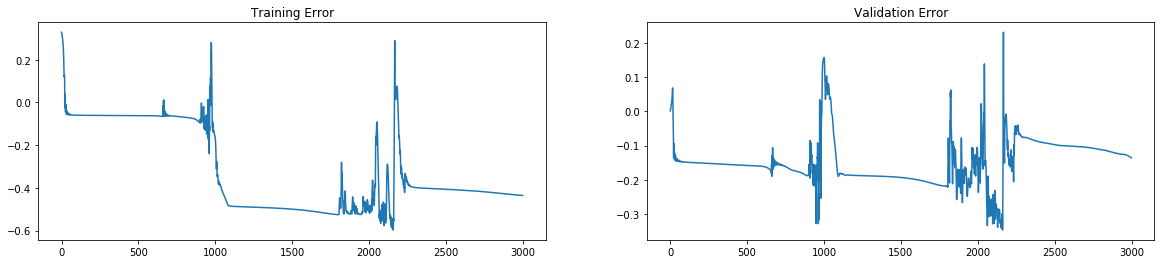

In [25]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(1,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.show()

In [28]:
def plot_result(traintest="train"): 
    if traintest == "train":
        X, A, minv, maxv = (X_train, A_train, min_train, max_train)
        samples = samples_train
        i = np.random.randint(n_train)
    else:
        X, A, minv, maxv  = (X_test, A_test, min_test, max_test)
        samples = samples_test
        i = np.random.randint(n_test)
        
    annotation = list(range(num_steps+1))
    xx = np.linspace(-1,1,200)
    yy = GP(X[i].reshape(1,-1),A[i],xx, minv[i], maxv[i])

    samples_x = samples[i]
    samples_y = GP(X[i].reshape(1,-1),A[i],samples_x, minv[i], maxv[i]).flatten()

    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xx,yy.flatten(),linewidth=3)
    ax.scatter(samples_x,samples_y,marker="x", color="k")
    
    for i, txt in enumerate(annotation):
        ax.annotate(str(txt), (samples_x[i],samples_y[i]),\
                    xytext=(samples_x[i]+np.random.uniform(-0.2,0.2),\
                            samples_y[i]+0.3), arrowprops=dict(facecolor='black', shrink=0.01))
    plt.show()
    
def plot_multiple(traintest="train",k=0):
    if traintest == "train":
        X, A, minv, maxv = (X_train, A_train, min_train, max_train)
        title_str = "Training Data"
        samples = samples_train
    else:
        X, A, minv, maxv  = (X_test, A_test, min_test, max_test)
        title_str = "Test Data"
        samples = samples_test
      
    xx = np.linspace(-1,1,200)
    
    plt.figure(figsize=(20,10))
    for i in range(16):
        samples_x = samples[i]
        samples_y = GP(X[i].reshape(1,-1),A[i],samples_x, minv[i], maxv[i]).flatten()
        yy = GP(X[i].reshape(1,-1),A[i],xx, minv[i], maxv[i]).flatten()
        plt.subplot(4,4,i+1)
        plt.plot(xx,yy,linewidth=3)
        plt.scatter(samples_x,samples_y,color="k")
        #plt.title(str(["%.1f" % x for x in samples_x]))
        
    plt.suptitle(title_str)
    plt.show()

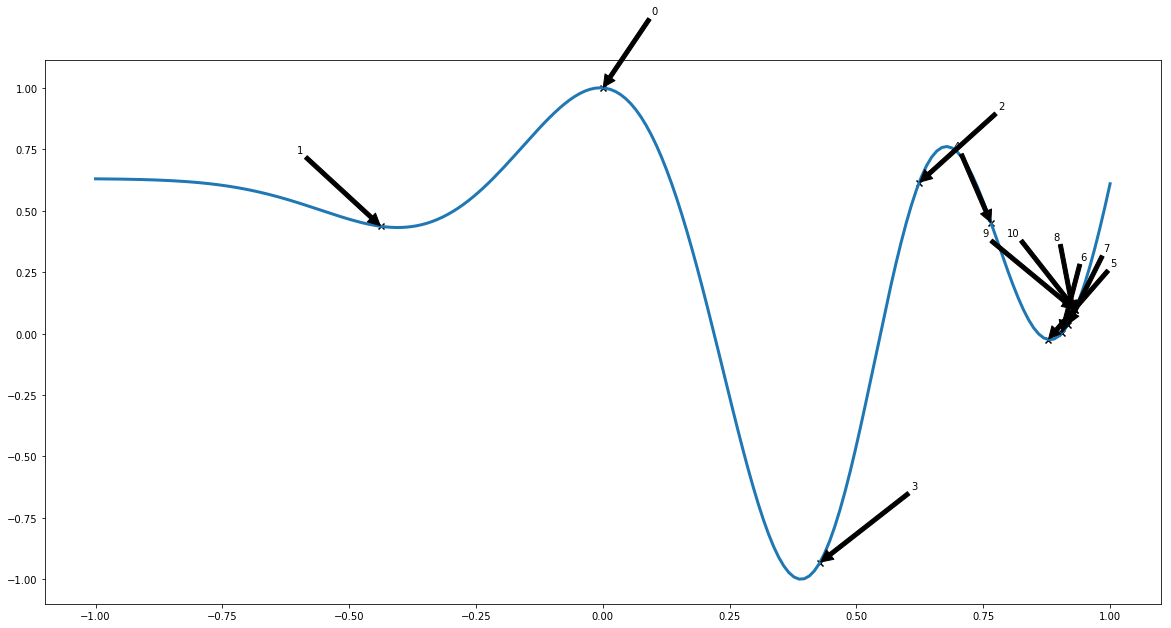

In [30]:
plot_result()

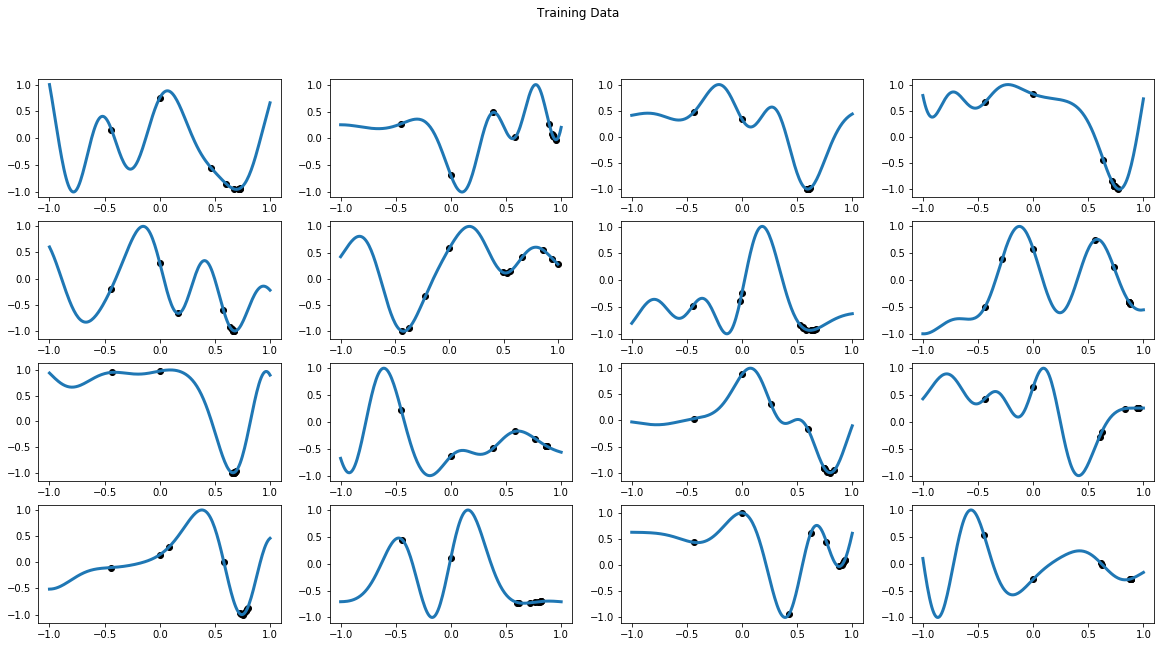

In [31]:
plot_multiple("train")

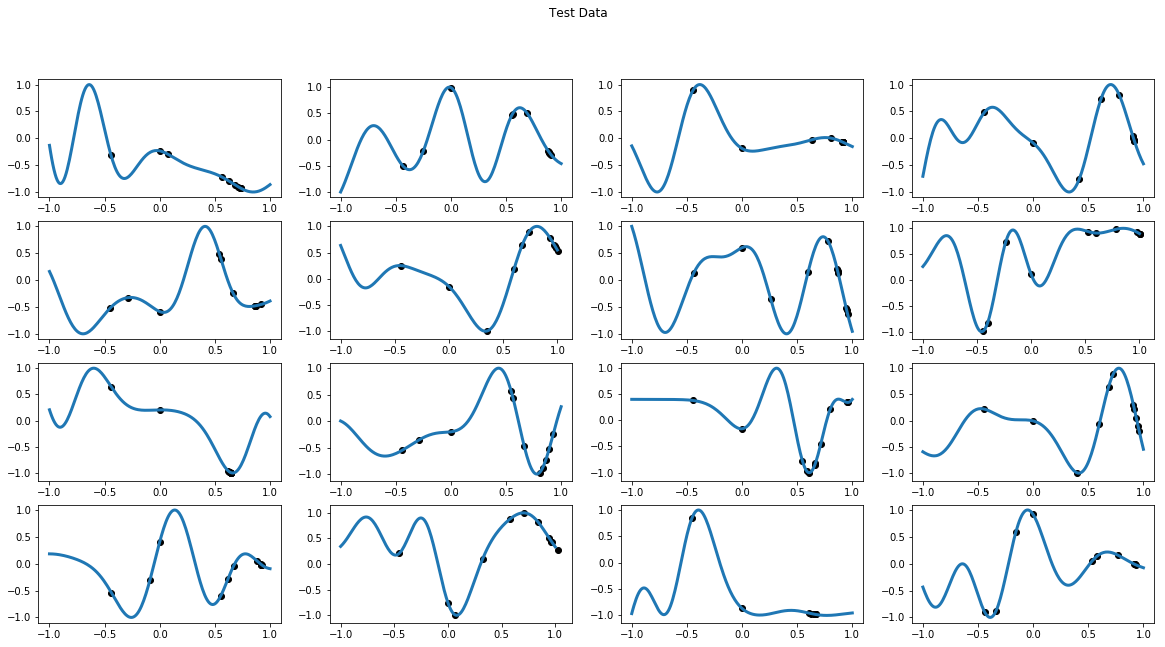

In [32]:
plot_multiple("test")